In [11]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44797")
client

<Client: 'tcp://127.0.0.1:44797' processes=2 threads=8, memory=15.55 GiB>

## Notes: the Zarr stores used are subsets of the actual big ones that we have for experimental purposes.

#### The subsets contain aggregated data of multiple NetCDF files into Zarr, which is good enough to demonstrate how a Zarr store's region can be updated.

#### `After` cells should be executed only after Prefect flows finished

Python imports

In [1]:
from datetime import datetime
import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_zarr_store(store_path: str) -> fsspec.FSMap:
    mapper = fsspec.get_mapper(store_path, check=False)
    return mapper

def np_dt64_to_dt(in_datetime: np.datetime64) -> str:
    """Convert numpy datetime64 to datetime"""
    dt = datetime.fromtimestamp(in_datetime.astype(int) / 1e9)
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

# SST

In [12]:
%time

sst_store_path = 's3://imos-data-lab-optimised/4428/sst/'
sst_store = get_zarr_store(sst_store_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


### Write empty chunks

Before

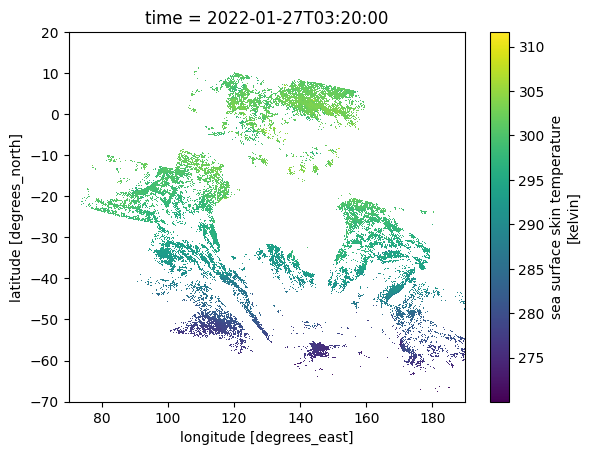

In [13]:
sst_ds = xr.open_zarr(sst_store)
sst_region_index = 26
sst_ds.isel(time=sst_region_index).sea_surface_temperature.plot()

Prefect logs:

![](https://i2.paste.pics/d3131f049be61834c78c63bcd75c5db0.png)

After

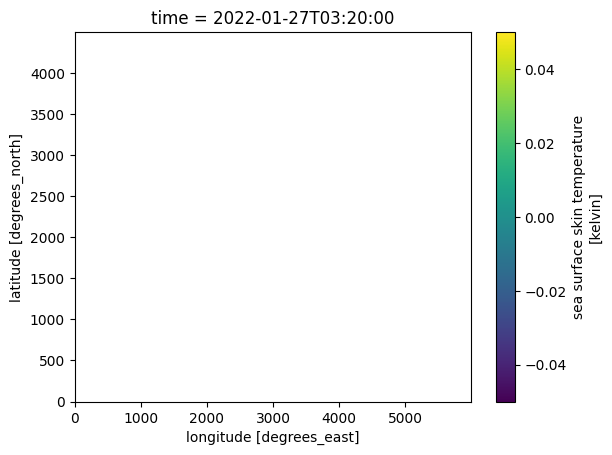

In [14]:
updated_sst_ds = xr.open_zarr(sst_store)
sst_region_index = 26
updated_sst_ds.isel(time=sst_region_index).sea_surface_temperature.plot()

### Write revised data

#### Before

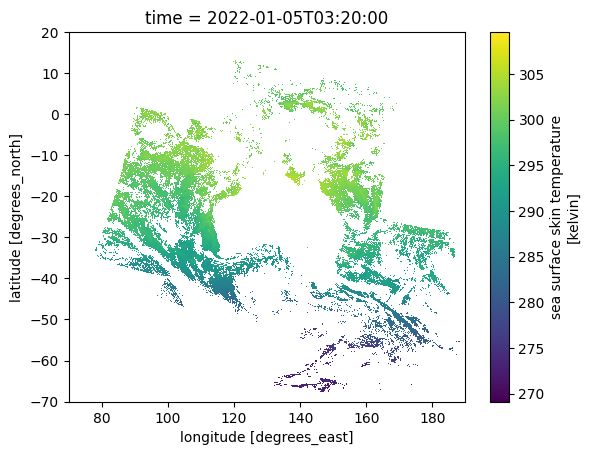

In [17]:
sst_ds_2 = xr.open_zarr(sst_store)
sst_region_index = 4
sst_ds_2.isel(time=sst_region_index).sea_surface_temperature.plot()

Prefect logs:

![](https://i2.paste.pics/abbbfeabb8568d2f57ced4dffb21e981.png)

Used `nco` to change the NetCDF file values: http://research.jisao.washington.edu/data_sets/nco/

- Download the original file:

```shell
vhnguyen@IMOS:~$ aws s3 cp s3://imos-data/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc ./20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc --copy-props none

```

- Double the sea_surface_temperature values and export to new NetCDF file:

```shell
vhnguyen@IMOS:~$ ncap2 -s 'sea_surface_temperature=sea_surface_temperature*2' 20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc 20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc
```

- Upload revised file to raw bucket:

```shell
vhnguyen@IMOS:~$ aws s3 cp ./20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc s3://update-zarr-region-raw/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220105032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc --copy-props none
```

#### After (doubled sea_surface_temperature values: notice the **axis values**)

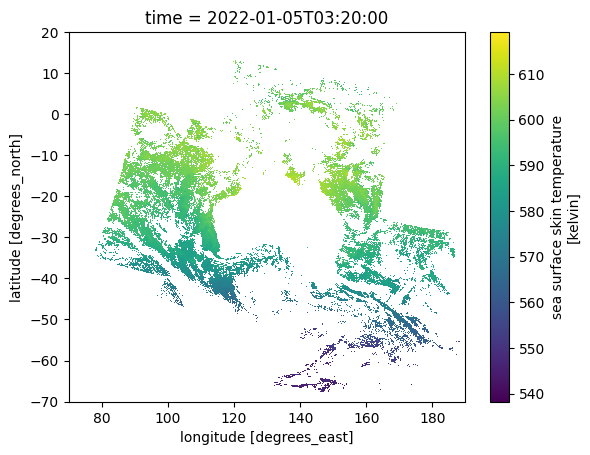

In [18]:
updated_sst_ds_2 = xr.open_zarr(sst_store)
sst_region_index = 4
updated_sst_ds_2.isel(time=sst_region_index).sea_surface_temperature.plot()

### Append new data

#### Before: Look at `time`: `{'time': (10, 10, 9)}`

There are 29 files ingested and aggregated to the Zarr store. 

Zarr store chunk's shape is `(10, 1000, 1000)`, but this pipeline processes 1 file per call, shape is `(1, 1000, 1000)`.

If 5 more files appended (34 in total), `time` would be `{'time': (10, 10, 10, 4)}`

In [23]:
sst_ds = xr.open_zarr(sst_store)
sst_ds.chunks

Frozen({'time': (10, 10, 9), 'lat': (1000, 1000, 1000, 1000, 500), 'lon': (1000, 1000, 1000, 1000, 1000, 1000)})

Upload new file that hasn't been ingested to current Zarr store

```shell
vhnguyen@IMOS:~$ aws s3 cp s3://imos-data/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220130032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc s3://update-zarr-region-raw/IMOS/SRS/SST/ghrsst/L3S-1d/day/2022/20220130032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc --copy-props none
```

(Note: after executing this command, the file is ingested to the Zarr store)

Prefect logs:

![](https://i2.paste.pics/80e149a2df6536f03089c77ac7c14eb1.png)

#### After: `time` is now be `{'time': (10, 10, 10)}`

In [24]:
updated_sst_ds_3 = xr.open_zarr(sst_store)
updated_sst_ds_3.chunks

Frozen({'time': (10, 10, 10), 'lat': (1000, 1000, 1000, 1000, 500), 'lon': (1000, 1000, 1000, 1000, 1000, 1000)})

# Argo

In [ ]:
%time

argo_store_path = 's3://imos-data-lab-optimised/4428/argo/'
argo_store = get_zarr_store(argo_store_path)

### Write empty chunks

Before

In [ ]:
argo_ds = xr.open_zarr(argo_store)
argo_region_index = 26
plt.scatter(argo_ds.PSAL_ADJUSTED[argo_region_index], argo_ds.TEMP_ADJUSTED[argo_region_index])
plt.xlabel('Salinity')
plt.ylabel('Temperature (Ã‚Â°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (argo_ds.PLATFORM_NUMBER[argo_region_index].values, 
                                    np_dt64_to_dt(argo_ds.JULD[argo_region_index].values)))

After

In [ ]:
updated_argo_ds = xr.open_zarr(argo_store)
argo_region_index = 26
plt.scatter(updated_argo_ds.PSAL_ADJUSTED[argo_region_index], updated_argo_ds.TEMP_ADJUSTED[argo_region_index])
plt.xlabel('Salinity')
plt.ylabel('Temperature (Ã‚Â°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (updated_argo_ds.PLATFORM_NUMBER[argo_region_index].values, 
                                    np_dt64_to_dt(updated_argo_ds.JULD[argo_region_index].values)))

### Write revised data

Before

In [ ]:
argo_ds = xr.open_zarr(argo_store)
argo_region_index = 4
plt.scatter(argo_ds.PSAL_ADJUSTED[argo_region_index], argo_ds.TEMP_ADJUSTED[argo_region_index])
plt.xlabel('Salinity')
plt.ylabel('Temperature (Ã‚Â°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (argo_ds.PLATFORM_NUMBER[argo_region_index].values, 
                                    np_dt64_to_dt(argo_ds.JULD[argo_region_index].values)))

After

In [ ]:
updated_argo_ds = xr.open_zarr(argo_store)
argo_region_index = 4
plt.scatter(updated_argo_ds.PSAL_ADJUSTED[argo_region_index], updated_argo_ds.TEMP_ADJUSTED[argo_region_index])
plt.xlabel('Salinity')
plt.ylabel('Temperature (Ã‚Â°C)')
plt.grid()
plt.title('Argo Float #%d on %s' % (updated_argo_ds.PLATFORM_NUMBER[argo_region_index].values, 
                                    np_dt64_to_dt(updated_argo_ds.JULD[argo_region_index].values)))

### Append new data

Before

In [ ]:
argo_ds = xr.open_zarr(argo_store)
argo_ds.chunks

After

In [ ]:
updated_argo_ds = xr.open_zarr(argo_store)
updated_argo_ds.chunks